## Frank Lab NWB query framework (prototype) on Allen Institute data


In [1]:
%load_ext autoreload
%autoreload 2

# General
import os
import pynwb
import numpy as np
import pandas as pd
import networkx as nx

# Local
from nwb_query import *

# Plotting
import matplotlib.pyplot as plt

### Load the NWB File

In [2]:
data_dir = os.path.expanduser('~/Data/Allen_Inst/') 
nwb_filename = data_dir + 'ecephys_session_785402239.nwb'

io = pynwb.NWBHDF5IO(nwb_filename, mode='r')
nwbf = io.read()

print('Loaded %s' % nwb_filename)


Loaded /Users/ericmiller/Data/Allen_Inst/ecephys_session_785402239.nwb


### Analysis parameters

In [214]:
cluster_idx = 0    # which cluster to look at for single unit analyses
stim_of_interest = "static_gratings"
epoch_of_interest = 1 
speed_threshold = 20 # cm/s

### Dataset Query: Find the time intervals of all epochs and their stimulus types
#### NWBFile (one animal) --> mx2 numpy array (epoch start/stop)




In [215]:
# Stimulus epochs
epoch_ivls_array = np.column_stack((nwbf.epochs['start_time'][:], nwbf.epochs['stop_time'][:]))

# Also get the stimulus type (i.e. stimulus_name) of each epoch
stim_types = nwbf.epochs['stimulus_name'][:]
stim_types[np.where(stim_types == '')[0]] = 'spontaneous_activity'

print("*** Epochs ***")
print("Total # of stimulus presentaions: %d" % len(epoch_ivls_array))
print("# of stimulus types: %d" % len(np.unique(stim_types)))

*** Epochs ***
Total # of stimulus presentaions: 70390
# of stimulus types: 8


### Analysis: Compute inter-stimulus intervals


In [216]:
# Possible ISIs: end of epoch n to start of epoch n+1
isi_start = nwbf.epochs['stop_time'][:-2]
isi_end = nwbf.epochs['start_time'][1:]

# Remove ISIs of 0 length
isi_ivls_array = []
for i in range(len(isi_start)):
    if isi_start[i] != isi_end[i]:
        isi_ivls_array.append([isi_start[i], isi_end[i]])

# Because we don't seem to have official start/stop times of neural recordings...

# ...if necessary, add ISIs for first spike to first epoch start
if nwbf.units['spike_times'][cluster_idx][0] != nwbf.epochs['start_time'][0]:
    isi_ivls_array.append(
        [nwbf.units['spike_times'][cluster_idx][0], nwbf.epochs['start_time'][0]])
    
# ...and if necessary, add ISIs for last epoch end to last spike
if nwbf.epochs['stop_time'][-1] != nwbf.units['spike_times'][cluster_idx][-1]:
    isi_ivls_array.append(
        [nwbf.epochs['stop_time'][-1], nwbf.units['spike_times'][cluster_idx][-1]])

# Convert to numpy array and build a TimeIntervals for queries
isi_ivls_array = np.array(isi_ivls_array)

print("*** Inter-stimulus intervals *** ")
print("Total # of ISIs: %d\n" % isi_ivls_array.shape[0])

*** Inter-stimulus intervals *** 
Total # of ISIs: 778



### Dataset Query: spiking of a given animal and cluster
#### Cluster spiking, epoch_intervals  --> PointData (spiking)


*** Spiking for cluster 0 ***
# of spikes = 6341
# of valid intervals = 1
duration of valid intervals = 9591.39 s
SNR = 0.39




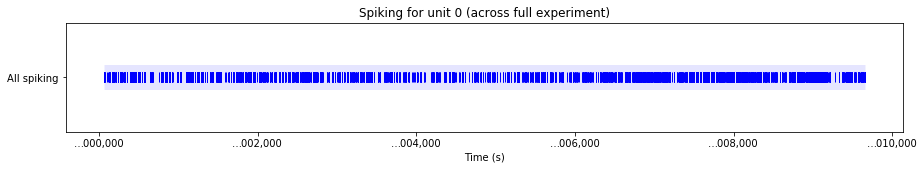

In [217]:
# Find all spike times for this cluster
spikes_t = nwbf.units['spike_times'][cluster_idx]

# Since we don't have a true start/end time of the recording session, we use
# the time of first and last spike as the start/stop valid interval, assuming
# no recording dropouts for the duration of the experiment
valid_intervals = TimeIntervals(np.array([spikes_t[0], spikes_t[-1]]))

# Build a PointData object with the spike times and valid intervals
spiking_all = PointData(point_times=spikes_t, valid_intervals=valid_intervals)

print('*** Spiking for cluster %s ***' % cluster_idx)
print('# of spikes = %d' % spiking_all.point_times.shape[0])
print('# of valid intervals = %d' % len(spiking_all.valid_intervals))
print('duration of valid intervals = %0.2f s' % np.sum(spiking_all.valid_intervals.durations()))
print('SNR = %0.2f' % nwbf.units['snr'][cluster_idx])
print('\n')

f = plt.figure(1, figsize=(15, 2))
ax1 = f.add_subplot(1, 1, 1)
spikeplots = [(spiking_all, 'All spiking')]
plot_PointData_multiple(spikeplots, axis=ax1)
plt.title('Spiking for unit %s (across full experiment)' % cluster_idx)

pass

### Dataset Query: spiking for a subset of clusters



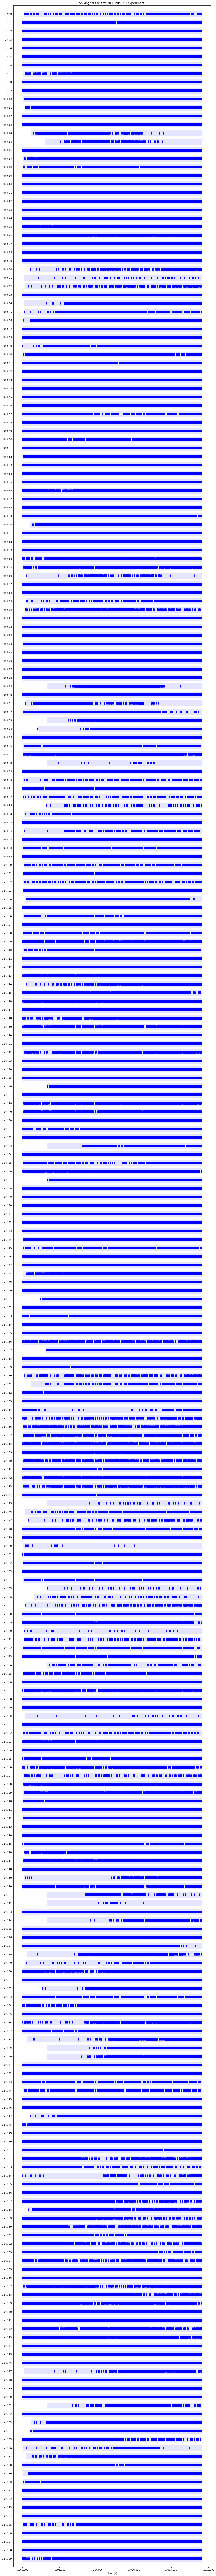

In [243]:
num_units = 300

spikes_all_clusters = np.array(nwbf.units['spike_times'][:])
spikeplots = []
for i in range(num_units):
    spikes = spikes_all_clusters[i]
    valid_start = min(min(spikes[0], isi_ivls_array[0, 0]), 
    valid_end = max(spikes[-1], isi_ivls_array[-1, 1])
    valid_intervals = TimeIntervals(np.array([valid_start, valid_end]))
    spiking = PointData(point_times=spikes, valid_intervals=valid_intervals)
    spikeplots.append((spiking, 'Unit %d' % i))
    
f = plt.figure(1, figsize=(15, 200))
ax1 = f.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)
plt.title('Spiking for the first %d units (full experiment)' % num_units)

pass

### Time Queries: Query for cluster spiking in the different epoch types
#### PointData (spiking), TimeIntervals (stimulus type) --> PointData (spiking)

Time queries into the spiking data for cluster 0
yields spiking and valid intervals for each stimulus type...

*** Spiking during Natural Images epochs ***
# of spikes = 1225
# of valid intervals = 3
total duration of valid intervals = 1488.74 s


*** Spiking during drifting_gratings epochs ***
# of spikes = 593
# of valid intervals = 630
total duration of valid intervals = 1261.07 s


*** Spiking during flash_250ms epochs ***
# of spikes = 52
# of valid intervals = 150
total duration of valid intervals = 37.56 s


*** Spiking during gabor_20_deg_250ms epochs ***
# of spikes = 652
# of valid intervals = 1
total duration of valid intervals = 912.00 s


*** Spiking during natural_movie_1 epochs ***
# of spikes = 527
# of valid intervals = 2
total duration of valid intervals = 600.50 s


*** Spiking during natural_movie_3 epochs ***
# of spikes = 522
# of valid intervals = 2
total duration of valid intervals = 1201.00 s


*** Spiking during spontaneous_activity epochs ***
# of spikes = 65

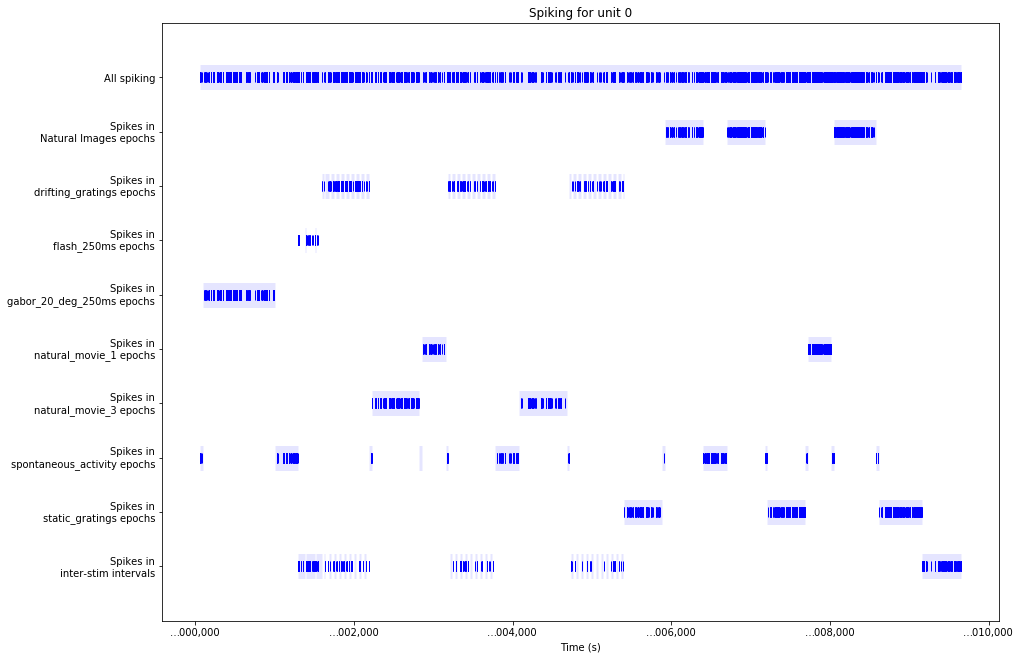

In [218]:
print("Time queries into the spiking data for cluster {0}\n".format(cluster_idx) + 
      "yields spiking and valid intervals for each stimulus type...\n")

# Within the loop, we will add a timeseries to this list for each stimulus type
spikeplots = [(spiking_all, 'All spiking')]

# Loop over all stimulus types, doing a TIME QUERY for spiking of the cluster during that stimulus type
for stim_of_interest in np.unique(stim_types):

    # Get the time intervals of the epochs with this stimulus type
    epochs_this_stim = np.where(stim_types==stim_of_interest)[0]
    ivls_array = epoch_ivls_array[epochs_this_stim, :]
#     ivls_array = np.array([[nwbf.epochs['start_time'][i], nwbf.epochs['stop_time'][i]] for i in epochs_this_stim])
    query_intervals = TimeIntervals(ivls_array)
    
    # Execute at TIME QUERY on spiking during epochs of interest
    spiking_behav = spiking_all.time_query(query_intervals)
    
    # append this stimulus type's spiking to the list for later plotting
    spikeplots.append((spiking_behav, 'Spikes in\n%s epochs' % stim_of_interest))

    print('*** Spiking during %s epochs ***' % stim_of_interest)
    print('# of spikes = %d' % spiking_behav.point_times.shape[0])
    print('# of valid intervals = %d' % len(spiking_behav.valid_intervals))
    print('total duration of valid intervals = %0.2f s' % np.sum(spiking_behav.valid_intervals.durations()))
    print('\n')
    
# Also analyze the inter-stimulus intervals
query_intervals = TimeIntervals(isi_ivls_array)
spiking_behav = spiking_all.time_query(query_intervals)  # time query
spikeplots.append((spiking_behav, 'Spikes in\ninter-stim intervals'))
print('*** Spiking during inter-stim intervals ***')
print('# of spikes = %d' % spiking_behav.point_times.shape[0])
print('# of valid intervals = %d' % len(spiking_behav.valid_intervals))
print('total duration of valid intervals = %0.2f s' % np.sum(spiking_behav.valid_intervals.durations()))
print('\n')


# Plot spiking for all stimulus types
fig1 = plt.figure(1, figsize=(15, len(spikeplots)+1))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)
plt.title('Spiking for unit %s' % cluster_idx)

pass # suppress output

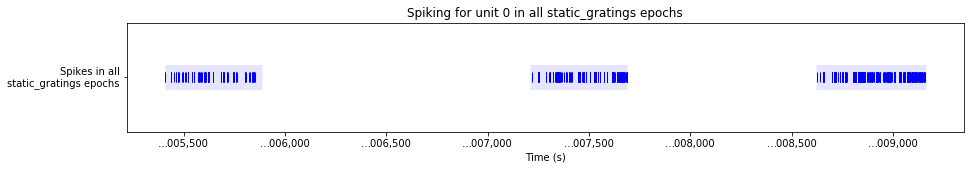

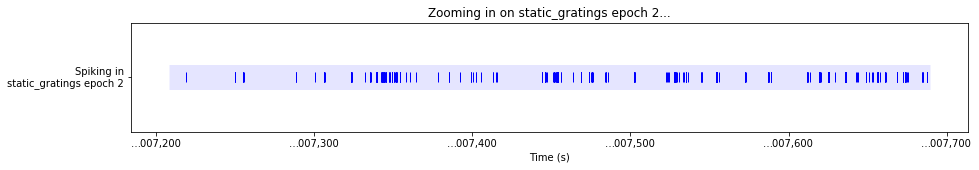

In [219]:
spikeplots = []

epochs_this_stim = np.where(stim_types==stim_of_interest)[0]
ivls_array = epoch_ivls_array[epochs_this_stim, :]
query_intervals = TimeIntervals(ivls_array)
    
# Execute at TIME QUERY on spiking during epochs of interest
spiking_during_stim = spiking_all.time_query(query_intervals)
    
# append this stimulus type's spiking to the list for later plotting
spikeplots.append((spiking_during_stim, 'Spikes in all\n%s epochs' % stim_of_interest))


# Plot spiking
fig1 = plt.figure(1, figsize=(15, len(spikeplots)+1))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)
plt.title('Spiking for unit %s in all %s epochs' % (cluster_idx, stim_of_interest))


# Query for spiking in just the first epoch of this stimulus type
spiking_first_stim = spiking_all.time_query(query_intervals[epoch_of_interest])

fig2 = plt.figure(2, figsize=(15,2))
ax2 = fig2.add_subplot(1, 1, 1)
plot_PointData_multiple([(spiking_first_stim, 'Spiking in\n%s epoch %d' % (stim_of_interest, epoch_of_interest+1))], axis=ax2)
ax2.set_title("Zooming in on %s epoch %d..." % (stim_of_interest, epoch_of_interest+1))


pass # suppress output

### Dataset Query: Animal speed across all epochs
#### NWBFile (one animal) --> ContinuousData (speed)

Text(0,0.5,'Velocity (m/s)')

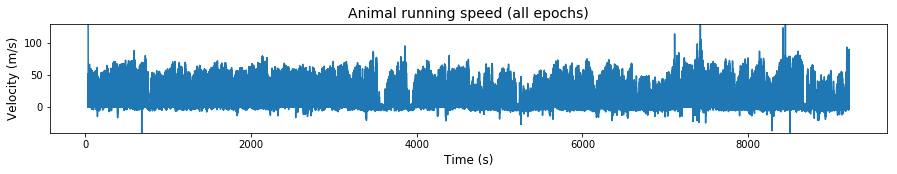

In [220]:
speed_timeseries = nwbf.modules['running']['speed']
speed_all_epochs = ContinuousData(samples=pd.DataFrame(data=speed_timeseries.data[()], columns=['speed']), 
                                  sample_times=speed_timeseries.timestamps[()], 
                                  valid_intervals=epoch_intervals)

plt.figure(figsize=(15,2))
plt.plot(speed_all_epochs.sample_times, speed_all_epochs.samples)
plt.ylim(-40, 130)
plt.title('Animal running speed (all epochs)', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Velocity (m/s)', fontsize=12)

### Time Query: animal speed in one epoch
#### ContinuousData (speed), epoch --> ContinuousData (speed in one epoch)

Text(0,0.5,'Velocity (cm/s)')

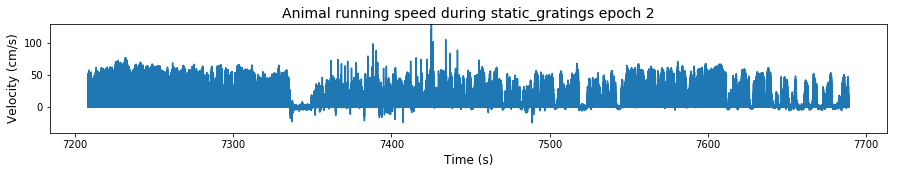

In [221]:
speed_one_epoch = speed_all_epochs.time_query(query_intervals[epoch_of_interest])

plt.figure(figsize=(15,2))
plt.plot(speed_one_epoch.sample_times, speed_one_epoch.samples)
plt.ylim(-40, 130)
plt.title('Animal running speed during %s epoch %d' % (stim_of_interest, epoch_of_interest+1), fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Velocity (cm/s)', fontsize=12)

### Analysis: Find time intervals where speed > threshold
#### ContinuousData (speed), lambda function --> EventData (time periods where animal speed > threshold)

*** Times where speed > threshold ***
# of events = 7033
duration of events = 109.21 s
# of valid intervals = 1
duration of intervals = 481.07 s


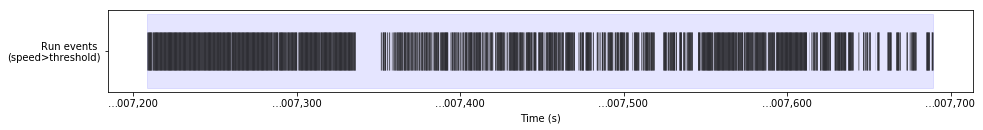

In [222]:
speed_threshold_fn = lambda x: x > speed_threshold

speed_events = speed_one_epoch.filter_intervals(speed_threshold_fn)

print('*** Times where speed > threshold ***')
print('# of events = %d' % len(speed_events.event_intervals))
print('duration of events = %0.2f s' % np.sum(speed_events.durations()))
print('# of valid intervals = %d' % len(speed_events.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(speed_events.valid_durations()))

# TODO: Plot continuous speed
fig1 = plt.figure(1, figsize=(15.5,1.5))
ax1 = fig1.add_subplot(1, 1, 1)
plot_EventData(speed_events, axis=ax1)
ax1.set_yticks([1])
ax1.set_yticklabels(['Run events \n(speed>threshold)']) # eventually use metadata from PointData object
pass # suppress output

### Query: spiking during time intervals where speed > threshold
#### PointData (spiking), EventData (bouts where speed > threshold) --> PointData (spiking)

*** Spiking where speed > threshold ***
# of spikes = 56
# of intervals = 7033
duration of intervals = 109.21 s



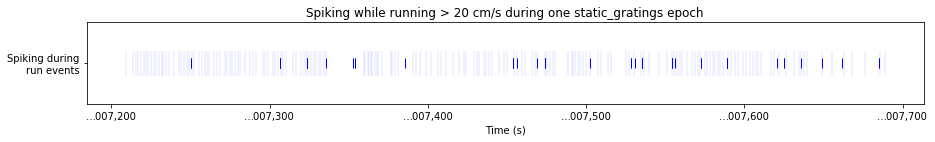

In [223]:
spiking_run = spiking_first_stim.time_query(speed_events)  # Use the built-in time query method on PointProcess

print('*** Spiking where speed > threshold ***')
print('# of spikes = %d' % len(spiking_run.point_times))
print('# of intervals = %d' % len(spiking_run.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_run.valid_intervals.durations()))
print()

# print(spiking_run)

# Plot spiking
fig1 = plt.figure(1, figsize=(15,1.5))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple([(spiking_run, 'Spiking during\nrun events')], axis=ax1)
plt.title('Spiking while running > {0} cm/s during one {1} epoch'.format(speed_threshold, stim_of_interest))

pass # suppress output